# Chicory cutting line detection using a YOLOv8 model

For the prediction of the cutting line for chicory, we use a YOLOv8 model for keypoint detection purposes. The data was created by Wout Desaever, Master student at KU leuven Bruges (2022). The data was labeled by experts from Inagro and contains the bounding box and the cutting line of the chicory. The data was converted to YOLO format and to COCO format for visualisation. 

In [1]:
# Imports
import requests
from PIL import Image
from io import BytesIO
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

## Data analyis

The data folder contains a folder with images and a folder with labels in the YOLO format. This format has a .txt file for every image with one line for each annotation. Each line contains the image class, the normalized bounding box coordinates [x_center, y_center, width, height], and the normalized coordinates of the two points [x1, y1, x2, y2]. We also use a .json file with all labels in COCO format for visualization of the labels.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


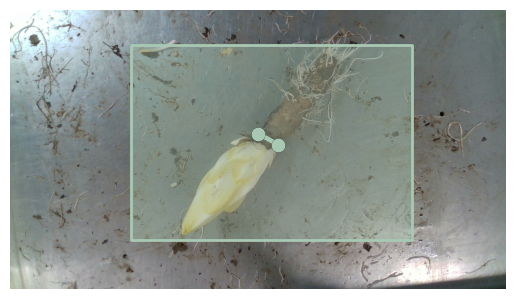

In [2]:
# Create a COCO object
coco = COCO('../../data/chicory_data_keypoints/witloof_dataset_coco.json')

# Get the annotations for this image
annotations = coco.loadAnns(coco.getAnnIds(imgIds=1))

# Get the image info
img_info = coco.loadImgs(1)[0]
height, width = img_info['height'], img_info['width']
file_name = img_info['file_name']
response = requests.get(file_name)
image = Image.open(BytesIO(response.content))

# Load and display instance annotations
plt.imshow(image); plt.axis('off')
coco.showAnns(annotations, draw_bbox=True)
plt.show()

## Data Preprocessing

For a proper pipeline, we will split our total dataset into a training, validation, and testset. De model gets trained on images from the training set. After each batch, the model is validated on the validation set. After training, we can evaluate the final model on the testset. The below command creates three autosplit .txt files that contain the paths to the images of the corresponding dataset for training, validation, and testing. 

In [3]:
# Split data in 80% training, 10% validation, and 10% test sets
ultralytics.data.utils.autosplit(path='../../data/chicory_data_keypoints/images', weights=(0.8, 0.1, 0.1), annotated_only=False)

Autosplitting images from ..\..\data\chicory_data_keypoints\images


  0%|          | 0/216 [00:00<?, ?it/s]

100%|██████████| 216/216 [00:00<00:00, 5975.90it/s]

## Model training

In the next step, we will train our model. The model that we use is a pretrained YOLOv8n-pose model that was trained on the COCO dataset. We use the Ultralytics API for the training and validation phase. More info on: https://docs.ultralytics.com/tasks/pose/. All model parameters are logged during training, all parameters can be visualized using Tensorboard which will be activated below.

In [4]:
# Load a YOLOv8 model for pose estimation
model = YOLO('yolov8n-pose.yaml').load('yolov8n-pose.pt')  # build from YAML and transfer weights

# Training params
epochs = 20 # All data is sent 'epoch' times through the network
image_size = 640 # All images are resized to this size before entering the network

# Train the model
results = model.train(data='../../data/chicory_data_keypoints/witloof_dataset.yaml', epochs=epochs, imgsz=image_size)

  0%|                                                                                                                  | 0.00/6.51M [00:00<?, ?B/s]

 17%|█████████████████▉                                                                                       | 1.11M/6.51M [00:00<00:00, 11.4MB/s]

 34%|███████████████████████████████████▍                                                                     | 2.20M/6.51M [00:00<00:00, 10.7MB/s]

 49%|███████████████████████████████████████████████████▉                                                     | 3.22M/6.51M [00:00<00:00, 8.62MB/s]

 73%|████████████████████████████████████████████████████████████████████████████▊                            | 4.77M/6.51M [00:00<00:00, 11.1MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 6.30M/6.51M [00:00<00:00, 12.6MB/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.51M/6.51M [00:00<00:00, 11.7MB/s]

Transferred 397/397 items from pretrained weights


Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)


engine\trainer: task=pose, mode=train, model=yolov8n-pose.yaml, data=../../data/chicory_data_keypoints/witloof_dataset.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=

Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[2, 2]



                   from  n    params  module                                       arguments                     


  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 


  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                


  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             


  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                


  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             


  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           


  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              


  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           


  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 


 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          


 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           


 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 


 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          


 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           


 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  


 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                


 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           


 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 


 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              


 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           


 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 


 22        [15, 18, 21]  1    823327  ultralytics.nn.modules.head.Pose             [1, [2, 2], [64, 128, 256]]   


YOLOv8n-pose summary: 250 layers, 3082863 parameters, 3082847 gradients, 8.4 GFLOPs


Transferred 361/397 items from pretrained weights


TensorBoard: Start with 'tensorboard --logdir ..\runs\pose\train', view at http://localhost:6006/


Freezing layer 'model.22.dfl.conv.weight'


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


  0%|                                                                                                                  | 0.00/6.23M [00:00<?, ?B/s]

 18%|███████████████████                                                                                      | 1.13M/6.23M [00:00<00:00, 11.7MB/s]

 36%|██████████████████████████████████████                                                                   | 2.26M/6.23M [00:00<00:00, 9.65MB/s]

 53%|███████████████████████████████████████████████████████▍                                                 | 3.29M/6.23M [00:00<00:00, 10.1MB/s]

 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 4.80M/6.23M [00:00<00:00, 12.2MB/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 6.00M/6.23M [00:00<00:00, 12.3MB/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 11.8MB/s]

AMP: checks passed ✅


train: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels.cache... 165 images, 0 backgr

train: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels.cache... 165 images, 0 backgr

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels...:   0%|          | 0/27 [00:0

val: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels... 27 images, 0 backgrounds, 0 

val: New cache created: C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_keypoints\labels.cache


Plotting labels to ..\runs\pose\train\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)


TensorBoard: model graph visualization added ✅


Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\pose\train
Starting training for 20 epochs...



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       1/20      2.23G      2.384     0.7529          0      3.183      2.207         34        640:   0%|          | 0/11 [00:00<?, ?it/s]

       1/20      2.23G      2.384     0.7529          0      3.183      2.207         34        640:   9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

       1/20      2.23G      2.374     0.7033          0      3.207      2.302         39        640:   9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

       1/20      2.23G      2.374     0.7033          0      3.207      2.302         39        640:  18%|█▊        | 2/11 [00:00<00:03,  2.38it/s]

       1/20      2.23G      2.339     0.7125          0      3.038      2.269         37        640:  18%|█▊        | 2/11 [00:01<00:03,  2.38it/s]

       1/20      2.23G      2.339     0.7125          0      3.038      2.269         37        640:  27%|██▋       | 3/11 [00:01<00:02,  2.68it/s]

       1/20      2.23G      2.365     0.7352          0      3.101      2.286         36        640:  27%|██▋       | 3/11 [00:01<00:02,  2.68it/s]

       1/20      2.23G      2.365     0.7352          0      3.101      2.286         36        640:  36%|███▋      | 4/11 [00:01<00:02,  2.77it/s]

       1/20      2.23G      2.414     0.7643          0      3.146      2.316         36        640:  36%|███▋      | 4/11 [00:01<00:02,  2.77it/s]

       1/20      2.23G      2.414     0.7643          0      3.146      2.316         36        640:  45%|████▌     | 5/11 [00:01<00:02,  2.96it/s]

       1/20      2.23G      2.459     0.7602          0      3.237      2.373         32        640:  45%|████▌     | 5/11 [00:02<00:02,  2.96it/s]

       1/20      2.23G      2.459     0.7602          0      3.237      2.373         32        640:  55%|█████▍    | 6/11 [00:02<00:01,  3.16it/s]

       1/20      2.23G      2.443     0.7774          0      3.228      2.372         36        640:  55%|█████▍    | 6/11 [00:02<00:01,  3.16it/s]

       1/20      2.23G      2.443     0.7774          0      3.228      2.372         36        640:  64%|██████▎   | 7/11 [00:02<00:01,  3.41it/s]

       1/20      2.23G      2.399     0.7794          0      3.194       2.34         38        640:  64%|██████▎   | 7/11 [00:02<00:01,  3.41it/s]

       1/20      2.23G      2.399     0.7794          0      3.194       2.34         38        640:  73%|███████▎  | 8/11 [00:02<00:00,  3.45it/s]

       1/20      2.23G      2.354     0.7775          0      3.074      2.324         33        640:  73%|███████▎  | 8/11 [00:02<00:00,  3.45it/s]

       1/20      2.23G      2.354     0.7775          0      3.074      2.324         33        640:  82%|████████▏ | 9/11 [00:02<00:00,  3.61it/s]

       1/20      2.23G      2.292     0.7663          0      2.942      2.264         38        640:  82%|████████▏ | 9/11 [00:03<00:00,  3.61it/s]

       1/20      2.23G      2.292     0.7663          0      2.942      2.264         38        640:  91%|█████████ | 10/11 [00:03<00:00,  3.70it/s

       1/20      2.27G      2.232      0.746          0      2.804      2.195         12        640:  91%|█████████ | 10/11 [00:03<00:00,  3.70it/s

       1/20      2.27G      2.232      0.746          0      2.804      2.195         12        640: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s

       1/20      2.27G      2.232      0.746          0      2.804      2.195         12        640: 100%|██████████| 11/11 [00:03<00:00,  3.11it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.754       0.63      0.719      0.429      0.841      0.784      0.903      0.789



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       2/20      2.08G      1.549     0.4617          0      1.503      1.564         37        640:   0%|          | 0/11 [00:00<?, ?it/s]

       2/20      2.08G      1.549     0.4617          0      1.503      1.564         37        640:   9%|▉         | 1/11 [00:00<00:03,  2.67it/s]

       2/20      2.08G      1.472     0.5951          0      1.362      1.463         45        640:   9%|▉         | 1/11 [00:00<00:03,  2.67it/s]

       2/20      2.08G      1.472     0.5951          0      1.362      1.463         45        640:  18%|█▊        | 2/11 [00:00<00:03,  2.90it/s]

       2/20      2.08G      1.448     0.5998          0       1.33      1.446         35        640:  18%|█▊        | 2/11 [00:00<00:03,  2.90it/s]

       2/20      2.08G      1.448     0.5998          0       1.33      1.446         35        640:  27%|██▋       | 3/11 [00:00<00:02,  3.19it/s]

       2/20      2.08G       1.37     0.5877          0      1.257      1.413         35        640:  27%|██▋       | 3/11 [00:01<00:02,  3.19it/s]

       2/20      2.08G       1.37     0.5877          0      1.257      1.413         35        640:  36%|███▋      | 4/11 [00:01<00:02,  3.49it/s]

       2/20      2.08G      1.346     0.5714          0      1.216      1.383         38        640:  36%|███▋      | 4/11 [00:01<00:02,  3.49it/s]

       2/20      2.08G      1.346     0.5714          0      1.216      1.383         38        640:  45%|████▌     | 5/11 [00:01<00:01,  3.68it/s]

       2/20      2.08G      1.323     0.5615          0      1.163      1.369         33        640:  45%|████▌     | 5/11 [00:01<00:01,  3.68it/s]

       2/20      2.08G      1.323     0.5615          0      1.163      1.369         33        640:  55%|█████▍    | 6/11 [00:01<00:01,  3.77it/s]

       2/20      2.08G      1.306      0.547          0      1.116      1.372         38        640:  55%|█████▍    | 6/11 [00:01<00:01,  3.77it/s]

       2/20      2.08G      1.306      0.547          0      1.116      1.372         38        640:  64%|██████▎   | 7/11 [00:01<00:01,  3.95it/s]

       2/20       2.1G      1.297     0.5413          0      1.097      1.353         48        640:  64%|██████▎   | 7/11 [00:02<00:01,  3.95it/s]

       2/20       2.1G      1.297     0.5413          0      1.097      1.353         48        640:  73%|███████▎  | 8/11 [00:02<00:00,  3.99it/s]

       2/20       2.1G      1.275     0.5193          0      1.057      1.329         32        640:  73%|███████▎  | 8/11 [00:02<00:00,  3.99it/s]

       2/20       2.1G      1.275     0.5193          0      1.057      1.329         32        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.10it/s]

       2/20       2.1G      1.253     0.5056          0      1.028      1.303         43        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.10it/s]

       2/20       2.1G      1.253     0.5056          0      1.028      1.303         43        640:  91%|█████████ | 10/11 [00:02<00:00,  4.08it/s

       2/20      2.14G      1.234     0.4988          0     0.9916       1.28         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.08it/s

       2/20      2.14G      1.234     0.4988          0     0.9916       1.28         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.992          1      0.995      0.698      0.992          1      0.995       0.91



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       3/20      2.08G       1.08     0.2934          0     0.7498      1.177         36        640:   0%|          | 0/11 [00:00<?, ?it/s]

       3/20      2.08G       1.08     0.2934          0     0.7498      1.177         36        640:   9%|▉         | 1/11 [00:00<00:02,  3.68it/s]

       3/20      2.08G      1.164     0.2984          0     0.8725      1.257         35        640:   9%|▉         | 1/11 [00:00<00:02,  3.68it/s]

       3/20      2.08G      1.164     0.2984          0     0.8725      1.257         35        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

       3/20       2.1G      1.098     0.2818          0     0.8724      1.214         39        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

       3/20       2.1G      1.098     0.2818          0     0.8724      1.214         39        640:  27%|██▋       | 3/11 [00:00<00:02,  3.95it/s]

       3/20       2.1G      1.035     0.3036          0     0.8261      1.172         40        640:  27%|██▋       | 3/11 [00:00<00:02,  3.95it/s]

       3/20       2.1G      1.035     0.3036          0     0.8261      1.172         40        640:  36%|███▋      | 4/11 [00:00<00:01,  4.10it/s]

       3/20       2.1G      1.051     0.3219          0     0.8321      1.173         39        640:  36%|███▋      | 4/11 [00:01<00:01,  4.10it/s]

       3/20       2.1G      1.051     0.3219          0     0.8321      1.173         39        640:  45%|████▌     | 5/11 [00:01<00:01,  4.07it/s]

       3/20       2.1G      1.046     0.3245          0     0.8255      1.168         42        640:  45%|████▌     | 5/11 [00:01<00:01,  4.07it/s]

       3/20       2.1G      1.046     0.3245          0     0.8255      1.168         42        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.16it/s]

       3/20       2.1G      1.059     0.3319          0     0.8186      1.173         38        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.16it/s]

       3/20       2.1G      1.059     0.3319          0     0.8186      1.173         38        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.13it/s]

       3/20       2.1G      1.053     0.3277          0     0.8202      1.176         36        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.13it/s]

       3/20       2.1G      1.053     0.3277          0     0.8202      1.176         36        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.20it/s]

       3/20       2.1G      1.061     0.3368          0     0.8207       1.18         42        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.20it/s]

       3/20       2.1G      1.061     0.3368          0     0.8207       1.18         42        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.17it/s]

       3/20       2.1G      1.077     0.3401          0     0.8337      1.188         37        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.17it/s]

       3/20       2.1G      1.077     0.3401          0     0.8337      1.188         37        640:  91%|█████████ | 10/11 [00:02<00:00,  4.22it/s

       3/20      2.16G      1.077     0.3323          0     0.8303      1.188         15        640:  91%|█████████ | 10/11 [00:02<00:00,  4.22it/s

       3/20      2.16G      1.077     0.3323          0     0.8303      1.188         15        640: 100%|██████████| 11/11 [00:02<00:00,  5.03it/s

       3/20      2.16G      1.077     0.3323          0     0.8303      1.188         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.997          1      0.995      0.669      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       4/20      2.08G      1.043     0.1892          0     0.8263      1.103         37        640:   0%|          | 0/11 [00:00<?, ?it/s]

       4/20      2.08G      1.043     0.1892          0     0.8263      1.103         37        640:   9%|▉         | 1/11 [00:00<00:02,  4.01it/s]

       4/20       2.1G      1.083     0.2183          0     0.7754      1.159         39        640:   9%|▉         | 1/11 [00:00<00:02,  4.01it/s]

       4/20       2.1G      1.083     0.2183          0     0.7754      1.159         39        640:  18%|█▊        | 2/11 [00:00<00:02,  3.94it/s]

       4/20       2.1G      1.129     0.2224          0     0.8388      1.193         37        640:  18%|█▊        | 2/11 [00:00<00:02,  3.94it/s]

       4/20       2.1G      1.129     0.2224          0     0.8388      1.193         37        640:  27%|██▋       | 3/11 [00:00<00:01,  4.08it/s]

       4/20       2.1G      1.109     0.2273          0     0.8337      1.172         41        640:  27%|██▋       | 3/11 [00:00<00:01,  4.08it/s]

       4/20       2.1G      1.109     0.2273          0     0.8337      1.172         41        640:  36%|███▋      | 4/11 [00:00<00:01,  4.01it/s]

       4/20       2.1G      1.104     0.2401          0     0.8159      1.176         34        640:  36%|███▋      | 4/11 [00:01<00:01,  4.01it/s]

       4/20       2.1G      1.104     0.2401          0     0.8159      1.176         34        640:  45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

       4/20       2.1G      1.066     0.2413          0     0.7826      1.161         37        640:  45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

       4/20       2.1G      1.066     0.2413          0     0.7826      1.161         37        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.07it/s]

       4/20       2.1G      1.047     0.2368          0     0.7748      1.159         30        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.07it/s]

       4/20       2.1G      1.047     0.2368          0     0.7748      1.159         30        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

       4/20       2.1G      1.031      0.258          0     0.7727      1.155         37        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

       4/20       2.1G      1.031      0.258          0     0.7727      1.155         37        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.09it/s]

       4/20       2.1G      1.039     0.2721          0       0.78      1.161         45        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.09it/s]

       4/20       2.1G      1.039     0.2721          0       0.78      1.161         45        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.15it/s]

       4/20       2.1G      1.061     0.2689          0     0.7916      1.161         36        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.15it/s]

       4/20       2.1G      1.061     0.2689          0     0.7916      1.161         36        640:  91%|█████████ | 10/11 [00:02<00:00,  4.07it/s

       4/20      2.14G      1.044     0.2647          0     0.7887       1.16          6        640:  91%|█████████ | 10/11 [00:02<00:00,  4.07it/s

       4/20      2.14G      1.044     0.2647          0     0.7887       1.16          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s

       4/20      2.14G      1.044     0.2647          0     0.7887       1.16          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.983          1      0.995      0.621      0.983          1      0.995      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       5/20      2.09G     0.9301     0.2785          0     0.9437      1.181         32        640:   0%|          | 0/11 [00:00<?, ?it/s]

       5/20      2.09G     0.9301     0.2785          0     0.9437      1.181         32        640:   9%|▉         | 1/11 [00:00<00:02,  3.45it/s]

       5/20      2.09G     0.9073     0.2848          0     0.8204      1.129         38        640:   9%|▉         | 1/11 [00:00<00:02,  3.45it/s]

       5/20      2.09G     0.9073     0.2848          0     0.8204      1.129         38        640:  18%|█▊        | 2/11 [00:00<00:02,  3.82it/s]

       5/20       2.1G     0.9446     0.2606          0     0.8165      1.158         32        640:  18%|█▊        | 2/11 [00:00<00:02,  3.82it/s]

       5/20       2.1G     0.9446     0.2606          0     0.8165      1.158         32        640:  27%|██▋       | 3/11 [00:00<00:02,  3.92it/s]

       5/20       2.1G      0.956      0.241          0     0.8054      1.165         32        640:  27%|██▋       | 3/11 [00:01<00:02,  3.92it/s]

       5/20       2.1G      0.956      0.241          0     0.8054      1.165         32        640:  36%|███▋      | 4/11 [00:01<00:01,  4.07it/s]

       5/20       2.1G     0.9698     0.2314          0     0.8101      1.171         39        640:  36%|███▋      | 4/11 [00:01<00:01,  4.07it/s]

       5/20       2.1G     0.9698     0.2314          0     0.8101      1.171         39        640:  45%|████▌     | 5/11 [00:01<00:01,  4.04it/s]

       5/20       2.1G     0.9911     0.2375          0     0.8145      1.179         37        640:  45%|████▌     | 5/11 [00:01<00:01,  4.04it/s]

       5/20       2.1G     0.9911     0.2375          0     0.8145      1.179         37        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.12it/s]

       5/20       2.1G     0.9888     0.2298          0     0.8084      1.168         34        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.12it/s]

       5/20       2.1G     0.9888     0.2298          0     0.8084      1.168         34        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.03it/s]

       5/20       2.1G      1.012      0.217          0     0.8277      1.176         42        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.03it/s]

       5/20       2.1G      1.012      0.217          0     0.8277      1.176         42        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.09it/s]

       5/20       2.1G      1.028     0.2243          0     0.8218      1.177         42        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.09it/s]

       5/20       2.1G      1.028     0.2243          0     0.8218      1.177         42        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.16it/s]

       5/20       2.1G      1.034      0.224          0     0.8207      1.183         35        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.16it/s]

       5/20       2.1G      1.034      0.224          0     0.8207      1.183         35        640:  91%|█████████ | 10/11 [00:02<00:00,  4.12it/s

       5/20      2.14G      1.037     0.2154          0     0.8038      1.178         12        640:  91%|█████████ | 10/11 [00:02<00:00,  4.12it/s

       5/20      2.14G      1.037     0.2154          0     0.8038      1.178         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.918      0.963      0.981      0.718      0.918      0.963      0.982      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       6/20      2.09G     0.9482     0.2102          0      0.734      1.095         43        640:   0%|          | 0/11 [00:00<?, ?it/s]

       6/20      2.09G     0.9482     0.2102          0      0.734      1.095         43        640:   9%|▉         | 1/11 [00:00<00:02,  4.06it/s]

       6/20       2.1G       1.02     0.2135          0     0.7721      1.211         37        640:   9%|▉         | 1/11 [00:00<00:02,  4.06it/s]

       6/20       2.1G       1.02     0.2135          0     0.7721      1.211         37        640:  18%|█▊        | 2/11 [00:00<00:02,  4.01it/s]

       6/20       2.1G      0.994      0.213          0     0.7525      1.195         42        640:  18%|█▊        | 2/11 [00:00<00:02,  4.01it/s]

       6/20       2.1G      0.994      0.213          0     0.7525      1.195         42        640:  27%|██▋       | 3/11 [00:00<00:01,  4.10it/s]

       6/20       2.1G      1.041     0.2161          0     0.7844      1.212         31        640:  27%|██▋       | 3/11 [00:00<00:01,  4.10it/s]

       6/20       2.1G      1.041     0.2161          0     0.7844      1.212         31        640:  36%|███▋      | 4/11 [00:00<00:01,  4.16it/s]

       6/20       2.1G       1.05     0.2266          0     0.8143      1.204         40        640:  36%|███▋      | 4/11 [00:01<00:01,  4.16it/s]

       6/20       2.1G       1.05     0.2266          0     0.8143      1.204         40        640:  45%|████▌     | 5/11 [00:01<00:01,  4.09it/s]

       6/20       2.1G      1.032     0.2223          0     0.8085       1.18         37        640:  45%|████▌     | 5/11 [00:01<00:01,  4.09it/s]

       6/20       2.1G      1.032     0.2223          0     0.8085       1.18         37        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.17it/s]

       6/20       2.1G      1.006     0.2156          0     0.7805      1.155         36        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.17it/s]

       6/20       2.1G      1.006     0.2156          0     0.7805      1.155         36        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.20it/s]

       6/20       2.1G      0.997     0.2181          0      0.774      1.147         34        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.20it/s]

       6/20       2.1G      0.997     0.2181          0      0.774      1.147         34        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.12it/s]

       6/20       2.1G     0.9968     0.2072          0     0.7804      1.146         34        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.12it/s]

       6/20       2.1G     0.9968     0.2072          0     0.7804      1.146         34        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.20it/s]

       6/20       2.1G      1.004     0.2014          0     0.7832      1.144         40        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.20it/s]

       6/20       2.1G      1.004     0.2014          0     0.7832      1.144         40        640:  91%|█████████ | 10/11 [00:02<00:00,  4.25it/s

       6/20      2.15G     0.9926     0.1929          0     0.7753      1.141         11        640:  91%|█████████ | 10/11 [00:02<00:00,  4.25it/s

       6/20      2.15G     0.9926     0.1929          0     0.7753      1.141         11        640: 100%|██████████| 11/11 [00:02<00:00,  5.01it/s

       6/20      2.15G     0.9926     0.1929          0     0.7753      1.141         11        640: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.957      0.817      0.945      0.772      0.921      0.861      0.963      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       7/20      2.08G     0.9594     0.1508          0     0.7758      1.054         37        640:   0%|          | 0/11 [00:00<?, ?it/s]

       7/20      2.08G     0.9594     0.1508          0     0.7758      1.054         37        640:   9%|▉         | 1/11 [00:00<00:02,  3.98it/s]

       7/20       2.1G     0.8983     0.1851          0     0.7188      1.055         41        640:   9%|▉         | 1/11 [00:00<00:02,  3.98it/s]

       7/20       2.1G     0.8983     0.1851          0     0.7188      1.055         41        640:  18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

       7/20       2.1G     0.9295     0.1731          0     0.7402      1.078         40        640:  18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

       7/20       2.1G     0.9295     0.1731          0     0.7402      1.078         40        640:  27%|██▋       | 3/11 [00:00<00:01,  4.10it/s]

       7/20       2.1G     0.9432     0.1666          0     0.7337      1.091         37        640:  27%|██▋       | 3/11 [00:00<00:01,  4.10it/s]

       7/20       2.1G     0.9432     0.1666          0     0.7337      1.091         37        640:  36%|███▋      | 4/11 [00:00<00:01,  4.19it/s]

       7/20       2.1G     0.9142     0.1599          0     0.7223      1.088         39        640:  36%|███▋      | 4/11 [00:01<00:01,  4.19it/s]

       7/20       2.1G     0.9142     0.1599          0     0.7223      1.088         39        640:  45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

       7/20       2.1G     0.9234     0.1619          0      0.716      1.089         40        640:  45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

       7/20       2.1G     0.9234     0.1619          0      0.716      1.089         40        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.17it/s]

       7/20       2.1G     0.9365     0.1624          0     0.7197        1.1         34        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.17it/s]

       7/20       2.1G     0.9365     0.1624          0     0.7197        1.1         34        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.25it/s]

       7/20       2.1G     0.9369     0.1624          0     0.7121        1.1         41        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.25it/s]

       7/20       2.1G     0.9369     0.1624          0     0.7121        1.1         41        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.28it/s]

       7/20       2.1G     0.9332     0.1682          0     0.7026      1.103         35        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.28it/s]

       7/20       2.1G     0.9332     0.1682          0     0.7026      1.103         35        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.20it/s]

       7/20       2.1G     0.9443     0.1656          0     0.7004      1.097         51        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.20it/s]

       7/20       2.1G     0.9443     0.1656          0     0.7004      1.097         51        640:  91%|█████████ | 10/11 [00:02<00:00,  4.26it/s

       7/20      2.15G     0.9502     0.1596          0     0.6996      1.092         12        640:  91%|█████████ | 10/11 [00:02<00:00,  4.26it/s

       7/20      2.15G     0.9502     0.1596          0     0.6996      1.092         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.961          1      0.995      0.761      0.961          1      0.995      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       8/20      2.22G     0.9725     0.1237          0     0.7201      1.092         40        640:   0%|          | 0/11 [00:00<?, ?it/s]

       8/20      2.22G     0.9725     0.1237          0     0.7201      1.092         40        640:   9%|▉         | 1/11 [00:00<00:02,  3.53it/s]

       8/20      2.22G      1.076     0.1571          0     0.7904       1.17         42        640:   9%|▉         | 1/11 [00:00<00:02,  3.53it/s]

       8/20      2.22G      1.076     0.1571          0     0.7904       1.17         42        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

       8/20      2.23G      1.063     0.1957          0     0.7749      1.152         35        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

       8/20      2.23G      1.063     0.1957          0     0.7749      1.152         35        640:  27%|██▋       | 3/11 [00:00<00:01,  4.13it/s]

       8/20      2.23G      1.052     0.1881          0     0.7812       1.13         35        640:  27%|██▋       | 3/11 [00:00<00:01,  4.13it/s]

       8/20      2.23G      1.052     0.1881          0     0.7812       1.13         35        640:  36%|███▋      | 4/11 [00:00<00:01,  4.11it/s]

       8/20      2.23G      1.043      0.182          0     0.7715       1.13         33        640:  36%|███▋      | 4/11 [00:01<00:01,  4.11it/s]

       8/20      2.23G      1.043      0.182          0     0.7715       1.13         33        640:  45%|████▌     | 5/11 [00:01<00:01,  4.19it/s]

       8/20      2.23G      1.049      0.176          0     0.7677       1.13         29        640:  45%|████▌     | 5/11 [00:01<00:01,  4.19it/s]

       8/20      2.23G      1.049      0.176          0     0.7677       1.13         29        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

       8/20      2.23G      1.048     0.1692          0     0.7703      1.154         41        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

       8/20      2.23G      1.048     0.1692          0     0.7703      1.154         41        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

       8/20      2.23G      1.031     0.1666          0      0.772      1.142         35        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

       8/20      2.23G      1.031     0.1666          0      0.772      1.142         35        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.22it/s]

       8/20      2.23G      1.019     0.1664          0     0.7646      1.135         44        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.22it/s]

       8/20      2.23G      1.019     0.1664          0     0.7646      1.135         44        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.26it/s]

       8/20      2.23G      1.014     0.1667          0      0.763      1.135         29        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.26it/s]

       8/20      2.23G      1.014     0.1667          0      0.763      1.135         29        640:  91%|█████████ | 10/11 [00:02<00:00,  4.28it/s

       8/20      2.29G      1.051     0.1617          0      0.794      1.173         11        640:  91%|█████████ | 10/11 [00:02<00:00,  4.28it/s

       8/20      2.29G      1.051     0.1617          0      0.794      1.173         11        640: 100%|██████████| 11/11 [00:02<00:00,  5.08it/s

       8/20      2.29G      1.051     0.1617          0      0.794      1.173         11        640: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.926      0.929       0.98      0.728      0.926      0.929       0.98       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

       9/20      2.08G      1.063     0.1111          0     0.8101      1.334         29        640:   0%|          | 0/11 [00:00<?, ?it/s]

       9/20      2.08G      1.063     0.1111          0     0.8101      1.334         29        640:   9%|▉         | 1/11 [00:00<00:02,  3.84it/s]

       9/20       2.1G      1.039     0.1283          0     0.8371      1.223         32        640:   9%|▉         | 1/11 [00:00<00:02,  3.84it/s]

       9/20       2.1G      1.039     0.1283          0     0.8371      1.223         32        640:  18%|█▊        | 2/11 [00:00<00:02,  4.14it/s]

       9/20       2.1G     0.9876     0.1368          0     0.8089       1.15         46        640:  18%|█▊        | 2/11 [00:00<00:02,  4.14it/s]

       9/20       2.1G     0.9876     0.1368          0     0.8089       1.15         46        640:  27%|██▋       | 3/11 [00:00<00:01,  4.21it/s]

       9/20       2.1G     0.9749     0.1378          0     0.7715      1.121         40        640:  27%|██▋       | 3/11 [00:00<00:01,  4.21it/s]

       9/20       2.1G     0.9749     0.1378          0     0.7715      1.121         40        640:  36%|███▋      | 4/11 [00:00<00:01,  4.14it/s]

       9/20       2.1G     0.9561     0.1407          0     0.7608      1.108         44        640:  36%|███▋      | 4/11 [00:01<00:01,  4.14it/s]

       9/20       2.1G     0.9561     0.1407          0     0.7608      1.108         44        640:  45%|████▌     | 5/11 [00:01<00:01,  4.22it/s]

       9/20       2.1G     0.9464     0.1393          0      0.746      1.103         37        640:  45%|████▌     | 5/11 [00:01<00:01,  4.22it/s]

       9/20       2.1G     0.9464     0.1393          0      0.746      1.103         37        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.26it/s]

       9/20       2.1G     0.9696     0.1438          0     0.7503       1.11         44        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.26it/s]

       9/20       2.1G     0.9696     0.1438          0     0.7503       1.11         44        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.29it/s]

       9/20       2.1G     0.9662     0.1584          0     0.7549      1.111         43        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.29it/s]

       9/20       2.1G     0.9662     0.1584          0     0.7549      1.111         43        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.19it/s]

       9/20       2.1G      0.965     0.1521          0     0.7442      1.113         34        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.19it/s]

       9/20       2.1G      0.965     0.1521          0     0.7442      1.113         34        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.26it/s]

       9/20       2.1G     0.9472      0.153          0     0.7327      1.105         37        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.26it/s]

       9/20       2.1G     0.9472      0.153          0     0.7327      1.105         37        640:  91%|█████████ | 10/11 [00:02<00:00,  4.30it/s

       9/20      2.15G      0.972     0.1437          0     0.7451      1.131         12        640:  91%|█████████ | 10/11 [00:02<00:00,  4.30it/s

       9/20      2.15G      0.972     0.1437          0     0.7451      1.131         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.47it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.957          1      0.995      0.716      0.957          1      0.995      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      10/20      2.22G     0.9533    0.09215          0     0.7766      1.123         39        640:   0%|          | 0/11 [00:00<?, ?it/s]

      10/20      2.22G     0.9533    0.09215          0     0.7766      1.123         39        640:   9%|▉         | 1/11 [00:00<00:02,  3.75it/s]

      10/20      2.22G      1.018     0.1125          0     0.7708      1.091         38        640:   9%|▉         | 1/11 [00:00<00:02,  3.75it/s]

      10/20      2.22G      1.018     0.1125          0     0.7708      1.091         38        640:  18%|█▊        | 2/11 [00:00<00:02,  4.10it/s]

      10/20      2.23G       1.05     0.1558          0     0.8126      1.132         32        640:  18%|█▊        | 2/11 [00:00<00:02,  4.10it/s]

      10/20      2.23G       1.05     0.1558          0     0.8126      1.132         32        640:  27%|██▋       | 3/11 [00:00<00:01,  4.22it/s]

      10/20      2.23G      1.051     0.1447          0     0.8109      1.129         42        640:  27%|██▋       | 3/11 [00:00<00:01,  4.22it/s]

      10/20      2.23G      1.051     0.1447          0     0.8109      1.129         42        640:  36%|███▋      | 4/11 [00:00<00:01,  4.25it/s]

      10/20      2.23G      1.064     0.1391          0     0.8335      1.138         34        640:  36%|███▋      | 4/11 [00:01<00:01,  4.25it/s]

      10/20      2.23G      1.064     0.1391          0     0.8335      1.138         34        640:  45%|████▌     | 5/11 [00:01<00:01,  4.18it/s]

      10/20      2.23G      1.064     0.1542          0     0.8233      1.144         36        640:  45%|████▌     | 5/11 [00:01<00:01,  4.18it/s]

      10/20      2.23G      1.064     0.1542          0     0.8233      1.144         36        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

      10/20      2.23G       1.05     0.1518          0     0.8046      1.139         38        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

      10/20      2.23G       1.05     0.1518          0     0.8046      1.139         38        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.26it/s]

      10/20      2.23G      1.052     0.1464          0     0.8129      1.138         48        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.26it/s]

      10/20      2.23G      1.052     0.1464          0     0.8129      1.138         48        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.29it/s]

      10/20      2.23G      1.036     0.1512          0     0.7928      1.125         47        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.29it/s]

      10/20      2.23G      1.036     0.1512          0     0.7928      1.125         47        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.22it/s]

      10/20      2.23G      1.024     0.1519          0     0.7844      1.122         36        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.22it/s]

      10/20      2.23G      1.024     0.1519          0     0.7844      1.122         36        640:  91%|█████████ | 10/11 [00:02<00:00,  4.27it/s

      10/20      2.29G      1.037     0.1436          0     0.7953       1.13         12        640:  91%|█████████ | 10/11 [00:02<00:00,  4.27it/s

      10/20      2.29G      1.037     0.1436          0     0.7953       1.13         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.47it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.994          1      0.995      0.761      0.994          1      0.995      0.986


Closing dataloader mosaic


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      11/20      2.22G     0.7581    0.09638          0     0.6866      1.136         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      11/20      2.22G     0.7581    0.09638          0     0.6866      1.136         16        640:   9%|▉         | 1/11 [00:00<00:05,  1.79it/s]

      11/20      2.23G       0.76    0.09914          0     0.6394       1.05         16        640:   9%|▉         | 1/11 [00:00<00:05,  1.79it/s]

      11/20      2.23G       0.76    0.09914          0     0.6394       1.05         16        640:  18%|█▊        | 2/11 [00:00<00:03,  2.54it/s]

      11/20      2.23G      0.738    0.09624          0     0.6074      1.048         16        640:  18%|█▊        | 2/11 [00:01<00:03,  2.54it/s]

      11/20      2.23G      0.738    0.09624          0     0.6074      1.048         16        640:  27%|██▋       | 3/11 [00:01<00:02,  3.03it/s]

      11/20      2.23G     0.7968    0.09942          0     0.6025      1.091         16        640:  27%|██▋       | 3/11 [00:01<00:02,  3.03it/s]

      11/20      2.23G     0.7968    0.09942          0     0.6025      1.091         16        640:  36%|███▋      | 4/11 [00:01<00:02,  3.38it/s]

      11/20      2.23G     0.8047    0.09585          0     0.5904      1.087         16        640:  36%|███▋      | 4/11 [00:01<00:02,  3.38it/s]

      11/20      2.23G     0.8047    0.09585          0     0.5904      1.087         16        640:  45%|████▌     | 5/11 [00:01<00:01,  3.58it/s]

      11/20      2.23G     0.8001    0.09661          0     0.5781      1.067         16        640:  45%|████▌     | 5/11 [00:01<00:01,  3.58it/s]

      11/20      2.23G     0.8001    0.09661          0     0.5781      1.067         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  3.74it/s]

      11/20      2.23G     0.8322     0.1047          0      0.582      1.066         16        640:  55%|█████▍    | 6/11 [00:02<00:01,  3.74it/s]

      11/20      2.23G     0.8322     0.1047          0      0.582      1.066         16        640:  64%|██████▎   | 7/11 [00:02<00:01,  3.92it/s]

      11/20      2.23G     0.8123     0.1032          0     0.5679      1.048         16        640:  64%|██████▎   | 7/11 [00:02<00:01,  3.92it/s]

      11/20      2.23G     0.8123     0.1032          0     0.5679      1.048         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.04it/s]

      11/20      2.23G     0.8325    0.09985          0     0.5676      1.048         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.04it/s]

      11/20      2.23G     0.8325    0.09985          0     0.5676      1.048         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.11it/s]

      11/20      2.23G     0.8835     0.0992          0     0.5762      1.075         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.11it/s]

      11/20      2.23G     0.8835     0.0992          0     0.5762      1.075         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.04it/s

      11/20      2.27G     0.8695     0.0995          0     0.5726      1.059          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.04it/s

      11/20      2.27G     0.8695     0.0995          0     0.5726      1.059          5        640: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.957      0.963      0.943      0.714      0.957      0.963      0.943      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      12/20      2.09G     0.8255    0.07782          0     0.5765      1.137         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      12/20      2.09G     0.8255    0.07782          0     0.5765      1.137         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.06it/s]

      12/20       2.1G     0.7666     0.0911          0     0.5796      1.059         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.06it/s]

      12/20       2.1G     0.7666     0.0911          0     0.5796      1.059         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.19it/s]

      12/20       2.1G     0.7961    0.09546          0     0.5956      1.088         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.19it/s]

      12/20       2.1G     0.7961    0.09546          0     0.5956      1.088         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.00it/s]

      12/20       2.1G     0.7532    0.09968          0     0.5678      1.037         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.00it/s]

      12/20       2.1G     0.7532    0.09968          0     0.5678      1.037         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.14it/s]

      12/20       2.1G     0.7761    0.09698          0     0.5671      1.063         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.14it/s]

      12/20       2.1G     0.7761    0.09698          0     0.5671      1.063         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.22it/s]

      12/20       2.1G     0.7641     0.1007          0     0.5663       1.05         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.22it/s]

      12/20       2.1G     0.7641     0.1007          0     0.5663       1.05         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

      12/20       2.1G     0.7634     0.1033          0     0.5657      1.045         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

      12/20       2.1G     0.7634     0.1033          0     0.5657      1.045         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.18it/s]

      12/20       2.1G     0.7489    0.09801          0     0.5542       1.03         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.18it/s]

      12/20       2.1G     0.7489    0.09801          0     0.5542       1.03         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.24it/s]

      12/20       2.1G     0.7533     0.1005          0     0.5472      1.023         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.24it/s]

      12/20       2.1G     0.7533     0.1005          0     0.5472      1.023         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.27it/s]

      12/20       2.1G     0.7406    0.09784          0      0.543      1.017         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.27it/s]

      12/20       2.1G     0.7406    0.09784          0      0.543      1.017         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.29it/s

      12/20      2.15G     0.7769     0.1118          0     0.5796      1.025          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.29it/s

      12/20      2.15G     0.7769     0.1118          0     0.5796      1.025          5        640: 100%|██████████| 11/11 [00:02<00:00,  5.08it/s

      12/20      2.15G     0.7769     0.1118          0     0.5796      1.025          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.993      0.926      0.991       0.78          1      0.953      0.993      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      13/20      2.08G     0.5983    0.09135          0     0.4902     0.8986         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      13/20      2.08G     0.5983    0.09135          0     0.4902     0.8986         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.02it/s]

      13/20       2.1G     0.6314    0.09361          0     0.5107     0.8974         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.02it/s]

      13/20       2.1G     0.6314    0.09361          0     0.5107     0.8974         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.20it/s]

      13/20       2.1G     0.6414    0.09121          0     0.5068     0.8973         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.20it/s]

      13/20       2.1G     0.6414    0.09121          0     0.5068     0.8973         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.29it/s]

      13/20       2.1G     0.6446    0.08932          0     0.5002      0.888         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.29it/s]

      13/20       2.1G     0.6446    0.08932          0     0.5002      0.888         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.15it/s]

      13/20       2.1G     0.6311    0.08921          0     0.4925     0.9092         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.15it/s]

      13/20       2.1G     0.6311    0.08921          0     0.4925     0.9092         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.21it/s]

      13/20       2.1G     0.6427    0.09057          0     0.4874     0.9199         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.21it/s]

      13/20       2.1G     0.6427    0.09057          0     0.4874     0.9199         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

      13/20       2.1G     0.6404     0.0891          0     0.4811     0.9219         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

      13/20       2.1G     0.6404     0.0891          0     0.4811     0.9219         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.28it/s]

      13/20       2.1G     0.6541     0.0941          0      0.484     0.9248         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.28it/s]

      13/20       2.1G     0.6541     0.0941          0      0.484     0.9248         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.15it/s]

      13/20       2.1G     0.6693     0.0952          0     0.4883     0.9547         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.15it/s]

      13/20       2.1G     0.6693     0.0952          0     0.4883     0.9547         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.22it/s]

      13/20       2.1G     0.6685     0.0934          0     0.4818     0.9579         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.22it/s]

      13/20       2.1G     0.6685     0.0934          0     0.4818     0.9579         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.27it/s

      13/20      2.15G     0.6668    0.09313          0     0.4756       0.95          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.27it/s

      13/20      2.15G     0.6668    0.09313          0     0.4756       0.95          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.47it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27          1          1      0.995      0.832          1          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      14/20      2.22G     0.6724    0.07709          0      0.423     0.8994         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      14/20      2.22G     0.6724    0.07709          0      0.423     0.8994         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.66it/s]

      14/20      2.22G      0.703    0.08628          0     0.4743     0.9086         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.66it/s]

      14/20      2.22G      0.703    0.08628          0     0.4743     0.9086         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.08it/s]

      14/20      2.23G     0.7509    0.08558          0     0.4896      1.043         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.08it/s]

      14/20      2.23G     0.7509    0.08558          0     0.4896      1.043         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.18it/s]

      14/20      2.23G     0.7219    0.09146          0      0.477      1.002         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.18it/s]

      14/20      2.23G     0.7219    0.09146          0      0.477      1.002         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.24it/s]

      14/20      2.23G     0.6916    0.09159          0     0.4758     0.9933         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.24it/s]

      14/20      2.23G     0.6916    0.09159          0     0.4758     0.9933         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

      14/20      2.23G     0.6778    0.09029          0     0.4741     0.9872         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

      14/20      2.23G     0.6778    0.09029          0     0.4741     0.9872         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.20it/s]

      14/20      2.23G     0.6653    0.08878          0      0.467     0.9803         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.20it/s]

      14/20      2.23G     0.6653    0.08878          0      0.467     0.9803         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.25it/s]

      14/20      2.23G      0.675      0.092          0     0.4696     0.9889         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.25it/s]

      14/20      2.23G      0.675      0.092          0     0.4696     0.9889         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.28it/s]

      14/20      2.23G     0.6721    0.09465          0     0.4747     0.9794         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.28it/s]

      14/20      2.23G     0.6721    0.09465          0     0.4747     0.9794         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.17it/s]

      14/20      2.23G     0.6658    0.09205          0     0.4708       0.98         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.17it/s]

      14/20      2.23G     0.6658    0.09205          0     0.4708       0.98         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.24it/s

      14/20      2.28G     0.6684    0.09021          0     0.4668     0.9897          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.24it/s

      14/20      2.28G     0.6684    0.09021          0     0.4668     0.9897          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.995          1      0.995      0.845      0.995          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      15/20      2.22G     0.8341    0.09904          0     0.4942     0.9934         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      15/20      2.22G     0.8341    0.09904          0     0.4942     0.9934         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.01it/s]

      15/20      2.23G     0.7471    0.09177          0     0.4672      0.976         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.01it/s]

      15/20      2.23G     0.7471    0.09177          0     0.4672      0.976         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

      15/20      2.23G     0.8085    0.08731          0     0.4778      1.046         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

      15/20      2.23G     0.8085    0.08731          0     0.4778      1.046         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.15it/s]

      15/20      2.23G     0.7411    0.08346          0     0.4691       1.02         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.15it/s]

      15/20      2.23G     0.7411    0.08346          0     0.4691       1.02         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.22it/s]

      15/20      2.23G     0.7044    0.08115          0     0.4585     0.9847         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.22it/s]

      15/20      2.23G     0.7044    0.08115          0     0.4585     0.9847         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.26it/s]

      15/20      2.23G     0.6689    0.07859          0     0.4489     0.9694         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.26it/s]

      15/20      2.23G     0.6689    0.07859          0     0.4489     0.9694         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.16it/s]

      15/20      2.23G     0.6838    0.08187          0     0.4536     0.9685         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.16it/s]

      15/20      2.23G     0.6838    0.08187          0     0.4536     0.9685         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.22it/s]

      15/20      2.23G     0.6679    0.08281          0       0.45     0.9657         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.22it/s]

      15/20      2.23G     0.6679    0.08281          0       0.45     0.9657         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.28it/s]

      15/20      2.23G     0.6634     0.0827          0     0.4455     0.9646         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.28it/s]

      15/20      2.23G     0.6634     0.0827          0     0.4455     0.9646         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.31it/s]

      15/20      2.23G     0.6631    0.08266          0     0.4468     0.9638         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.31it/s]

      15/20      2.23G     0.6631    0.08266          0     0.4468     0.9638         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.20it/s

      15/20      2.27G     0.6721    0.08309          0     0.4512     0.9614          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.20it/s

      15/20      2.27G     0.6721    0.08309          0     0.4512     0.9614          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.997          1      0.995      0.858      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      16/20      2.08G      0.577    0.07261          0     0.4297     0.8589         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      16/20      2.08G      0.577    0.07261          0     0.4297     0.8589         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.91it/s]

      16/20       2.1G     0.5621    0.06454          0     0.4181     0.8874         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.91it/s]

      16/20       2.1G     0.5621    0.06454          0     0.4181     0.8874         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.16it/s]

      16/20       2.1G      0.612    0.07898          0     0.4382     0.9088         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.16it/s]

      16/20       2.1G      0.612    0.07898          0     0.4382     0.9088         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.03it/s]

      16/20       2.1G     0.6457    0.07865          0     0.4397     0.9186         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.03it/s]

      16/20       2.1G     0.6457    0.07865          0     0.4397     0.9186         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.18it/s]

      16/20       2.1G     0.6172    0.08034          0     0.4336     0.9219         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.18it/s]

      16/20       2.1G     0.6172    0.08034          0     0.4336     0.9219         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

      16/20       2.1G     0.6332    0.07691          0     0.4413     0.9343         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

      16/20       2.1G     0.6332    0.07691          0     0.4413     0.9343         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.28it/s]

      16/20       2.1G     0.6441    0.07818          0     0.4442     0.9338         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.28it/s]

      16/20       2.1G     0.6441    0.07818          0     0.4442     0.9338         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

      16/20       2.1G     0.6529    0.07894          0     0.4465     0.9483         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

      16/20       2.1G     0.6529    0.07894          0     0.4465     0.9483         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.24it/s]

      16/20       2.1G     0.6402    0.07748          0     0.4426     0.9446         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.24it/s]

      16/20       2.1G     0.6402    0.07748          0     0.4426     0.9446         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.27it/s]

      16/20       2.1G     0.6459    0.07874          0      0.441     0.9524         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.27it/s]

      16/20       2.1G     0.6459    0.07874          0      0.441     0.9524         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.30it/s

      16/20      2.15G     0.6462    0.07901          0     0.4425     0.9526          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.30it/s

      16/20      2.15G     0.6462    0.07901          0     0.4425     0.9526          5        640: 100%|██████████| 11/11 [00:02<00:00,  5.04it/s

      16/20      2.15G     0.6462    0.07901          0     0.4425     0.9526          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.997          1      0.995      0.868      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      17/20      2.08G     0.7808     0.1986          0     0.5202     0.9451         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      17/20      2.08G     0.7808     0.1986          0     0.5202     0.9451         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.94it/s]

      17/20       2.1G     0.6957     0.1337          0     0.4707     0.9423         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.94it/s]

      17/20       2.1G     0.6957     0.1337          0     0.4707     0.9423         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.14it/s]

      17/20       2.1G     0.6628     0.1098          0     0.4491     0.9064         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.14it/s]

      17/20       2.1G     0.6628     0.1098          0     0.4491     0.9064         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.19it/s]

      17/20       2.1G     0.6472     0.1063          0     0.4458     0.8934         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.19it/s]

      17/20       2.1G     0.6472     0.1063          0     0.4458     0.8934         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.10it/s]

      17/20       2.1G     0.6476     0.1056          0     0.4413     0.8923         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.10it/s]

      17/20       2.1G     0.6476     0.1056          0     0.4413     0.8923         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

      17/20       2.1G     0.6611    0.09871          0     0.4614     0.9114         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

      17/20       2.1G     0.6611    0.09871          0     0.4614     0.9114         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.19it/s]

      17/20       2.1G      0.662    0.09509          0     0.4563     0.9292         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.19it/s]

      17/20       2.1G      0.662    0.09509          0     0.4563     0.9292         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.23it/s]

      17/20       2.1G     0.6521    0.09328          0     0.4438     0.9213         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.23it/s]

      17/20       2.1G     0.6521    0.09328          0     0.4438     0.9213         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.13it/s]

      17/20       2.1G     0.6377    0.09095          0     0.4403     0.9165         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.13it/s]

      17/20       2.1G     0.6377    0.09095          0     0.4403     0.9165         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.18it/s]

      17/20       2.1G     0.6409    0.08663          0      0.443     0.9211         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.18it/s]

      17/20       2.1G     0.6409    0.08663          0      0.443     0.9211         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.23it/s

      17/20      2.15G     0.6257    0.08592          0     0.4313     0.9169          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.23it/s

      17/20      2.15G     0.6257    0.08592          0     0.4313     0.9169          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.997          1      0.995      0.856      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      18/20      2.22G      0.766     0.0639          0     0.4402     0.9821         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      18/20      2.22G      0.766     0.0639          0     0.4402     0.9821         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.72it/s]

      18/20      2.22G     0.6812    0.06313          0     0.4371     0.9439         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.72it/s]

      18/20      2.22G     0.6812    0.06313          0     0.4371     0.9439         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.07it/s]

      18/20      2.23G     0.6528    0.06137          0     0.4306     0.9272         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.07it/s]

      18/20      2.23G     0.6528    0.06137          0     0.4306     0.9272         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.18it/s]

      18/20      2.23G     0.6408    0.06735          0      0.424     0.9425         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.18it/s]

      18/20      2.23G     0.6408    0.06735          0      0.424     0.9425         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.22it/s]

      18/20      2.23G     0.6383    0.06639          0     0.4229     0.9314         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.22it/s]

      18/20      2.23G     0.6383    0.06639          0     0.4229     0.9314         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.15it/s]

      18/20      2.23G     0.6272    0.06953          0     0.4263     0.9237         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.15it/s]

      18/20      2.23G     0.6272    0.06953          0     0.4263     0.9237         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.22it/s]

      18/20      2.23G     0.6095    0.06876          0     0.4153     0.9141         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.22it/s]

      18/20      2.23G     0.6095    0.06876          0     0.4153     0.9141         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.28it/s]

      18/20      2.23G     0.6069    0.07016          0     0.4104     0.9121         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.28it/s]

      18/20      2.23G     0.6069    0.07016          0     0.4104     0.9121         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.24it/s]

      18/20      2.23G     0.6006    0.07157          0     0.4104     0.9087         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.24it/s]

      18/20      2.23G     0.6006    0.07157          0     0.4104     0.9087         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.16it/s]

      18/20      2.23G     0.6086    0.07423          0     0.4172     0.9148         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.16it/s]

      18/20      2.23G     0.6086    0.07423          0     0.4172     0.9148         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.22it/s

      18/20      2.28G     0.6335    0.07463          0     0.4195     0.9635          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.22it/s

      18/20      2.28G     0.6335    0.07463          0     0.4195     0.9635          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.992          1      0.995      0.877      0.992          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      19/20      2.22G     0.6757    0.08261          0     0.4237     0.9248         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      19/20      2.22G     0.6757    0.08261          0     0.4237     0.9248         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.03it/s]

      19/20      2.23G     0.7079    0.08394          0     0.4366       1.06         16        640:   9%|▉         | 1/11 [00:00<00:02,  4.03it/s]

      19/20      2.23G     0.7079    0.08394          0     0.4366       1.06         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

      19/20      2.23G     0.6665    0.07925          0     0.4229     0.9971         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

      19/20      2.23G     0.6665    0.07925          0     0.4229     0.9971         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.14it/s]

      19/20      2.23G     0.6165    0.07477          0     0.4114     0.9676         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.14it/s]

      19/20      2.23G     0.6165    0.07477          0     0.4114     0.9676         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.22it/s]

      19/20      2.23G     0.6172    0.07921          0     0.4068     0.9575         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.22it/s]

      19/20      2.23G     0.6172    0.07921          0     0.4068     0.9575         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.25it/s]

      19/20      2.23G     0.6014    0.07675          0     0.3976     0.9399         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.25it/s]

      19/20      2.23G     0.6014    0.07675          0     0.3976     0.9399         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.16it/s]

      19/20      2.23G     0.5778    0.07615          0      0.394     0.9264         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.16it/s]

      19/20      2.23G     0.5778    0.07615          0      0.394     0.9264         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

      19/20      2.23G     0.5761    0.07713          0     0.3896     0.9249         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.17it/s]

      19/20      2.23G     0.5761    0.07713          0     0.3896     0.9249         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.25it/s]

      19/20      2.23G     0.5649    0.07335          0     0.3881      0.914         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.25it/s]

      19/20      2.23G     0.5649    0.07335          0     0.3881      0.914         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.27it/s]

      19/20      2.23G     0.5625    0.07207          0     0.3862      0.913         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.27it/s]

      19/20      2.23G     0.5625    0.07207          0     0.3862      0.913         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.19it/s

      19/20      2.27G     0.5777    0.07063          0     0.3886     0.9088          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.19it/s

      19/20      2.27G     0.5777    0.07063          0     0.3886     0.9088          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.991          1      0.995       0.89      0.991          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]

      20/20      2.08G     0.4454    0.06336          0     0.3192     0.8683         16        640:   0%|          | 0/11 [00:00<?, ?it/s]

      20/20      2.08G     0.4454    0.06336          0     0.3192     0.8683         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.99it/s]

      20/20       2.1G     0.4426    0.06821          0     0.3395     0.8708         16        640:   9%|▉         | 1/11 [00:00<00:02,  3.99it/s]

      20/20       2.1G     0.4426    0.06821          0     0.3395     0.8708         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

      20/20       2.1G     0.4694    0.06401          0     0.3514     0.8839         16        640:  18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

      20/20       2.1G     0.4694    0.06401          0     0.3514     0.8839         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.03it/s]

      20/20       2.1G     0.4943    0.06636          0     0.3621     0.8913         16        640:  27%|██▋       | 3/11 [00:00<00:01,  4.03it/s]

      20/20       2.1G     0.4943    0.06636          0     0.3621     0.8913         16        640:  36%|███▋      | 4/11 [00:00<00:01,  4.13it/s]

      20/20       2.1G     0.5187    0.06585          0     0.3647     0.9358         16        640:  36%|███▋      | 4/11 [00:01<00:01,  4.13it/s]

      20/20       2.1G     0.5187    0.06585          0     0.3647     0.9358         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.21it/s]

      20/20       2.1G      0.542    0.07262          0      0.376     0.9439         16        640:  45%|████▌     | 5/11 [00:01<00:01,  4.21it/s]

      20/20       2.1G      0.542    0.07262          0      0.376     0.9439         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

      20/20       2.1G     0.5236    0.07067          0     0.3706     0.9332         16        640:  55%|█████▍    | 6/11 [00:01<00:01,  4.24it/s]

      20/20       2.1G     0.5236    0.07067          0     0.3706     0.9332         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.18it/s]

      20/20       2.1G     0.5319    0.06922          0     0.3711     0.9276         16        640:  64%|██████▎   | 7/11 [00:01<00:00,  4.18it/s]

      20/20       2.1G     0.5319    0.06922          0     0.3711     0.9276         16        640:  73%|███████▎  | 8/11 [00:01<00:00,  4.24it/s]

      20/20       2.1G     0.5351    0.06807          0     0.3701     0.9209         16        640:  73%|███████▎  | 8/11 [00:02<00:00,  4.24it/s]

      20/20       2.1G     0.5351    0.06807          0     0.3701     0.9209         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.28it/s]

      20/20       2.1G     0.5306    0.06755          0     0.3678     0.9132         16        640:  82%|████████▏ | 9/11 [00:02<00:00,  4.28it/s]

      20/20       2.1G     0.5306    0.06755          0     0.3678     0.9132         16        640:  91%|█████████ | 10/11 [00:02<00:00,  4.29it/s

      20/20      2.15G     0.5423    0.06971          0     0.3721     0.9179          5        640:  91%|█████████ | 10/11 [00:02<00:00,  4.29it/s

      20/20      2.15G     0.5423    0.06971          0     0.3721     0.9179          5        640: 100%|██████████| 11/11 [00:02<00:00,  5.07it/s

      20/20      2.15G     0.5423    0.06971          0     0.3721     0.9179          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.989          1      0.995      0.884      0.989          1      0.995      0.992



20 epochs completed in 0.040 hours.


Optimizer stripped from ..\runs\pose\train\weights\last.pt, 6.4MB


Optimizer stripped from ..\runs\pose\train\weights\best.pt, 6.4MB



Validating ..\runs\pose\train\weights\best.pt...


Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)


YOLOv8n-pose summary (fused): 187 layers, 3077567 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|        

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|████████

                   all         27         27      0.991          1      0.995       0.89      0.991          1      0.995      0.995


Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.6ms postprocess per image


Results saved to ..\runs\pose\train


# Model validation

After training, we load the best model and perform a validation step on the test data. Afterwards, we show some predictions. 

In [5]:
# Load a pretrained YOLOv8n model
model = YOLO('../runs/pose/train3/weights/best.pt')

⚠️ GitHub assets check failure for https://api.github.com/repos/ultralytics/assets/releases/tags/v8.1.0: 403 rate limit exceeded


⚠️ GitHub assets check failure for https://api.github.com/repos/ultralytics/assets/releases/latest: 403 rate limit exceeded


FileNotFoundError: [Errno 2] No such file or directory: '..\\runs\\pose\\train3\\weights\\best.pt'

In [ ]:
# Validate the model
metrics = model.val(split='test')

In [ ]:
# Predict with the model
results = model('../../data/chicory_data_keypoints/autosplit_test.txt', stream=True)  # predict on an image

# Plot results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)
    plt.show()